In [1]:
import snap
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def load_graph_weights(path="hw1-q2.graph"):

    g = snap.TUNGraph.Load(snap.TFIn(path))

    return g


def extract_basic_feature(node, graph):
    """
    Calculate three basic features for input node v
    1. degree of v
    2. number of edges in the egonet of node v
       here we have to iterate every node
    3. number of edges enter or leaving the egonet of node v
       here it's a undirected and unweighted graph, so we 
       can simplely count it with (tot_edges-inner_edges)
    Note that inner_edges and double edges 
    count every inner edge twice
    """
    
    v = [node.GetDeg()]
    tot_edges = v[0]
    nbrs = set([node.GetId()])
    for i in range(v[0]):
        cur_nbr = graph.GetNI(node.GetNbrNId(i))
        nbrs.add(cur_nbr.GetId())
        tot_edges += cur_nbr.GetDeg()
    
    inner_edges = v[0]
    for i in range(v[0]):
        cur_nbr = graph.GetNI(node.GetNbrNId(i))
        cur_nbr_deg = cur_nbr.GetDeg()
        for j in range(cur_nbr_deg):
            inner_edges += cur_nbr.GetNbrNId(j) in nbrs
     
    v.append(inner_edges//2)
    v.append(tot_edges - inner_edges)

    return np.array(v)

In [3]:
def cal_cos_sim(a, b):
    if np.linalg.norm(a) == 0 or np.linalg.norm(b) == 0:
        return 0.0
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


def cal_initial_feature(graph):
    v_mat = []
    for node in graph.Nodes():
        v_mat.append(extract_basic_feature(node, graph))
    return np.array(v_mat)


def aggregrate(v, graph):
    v_ori = v.copy()
    n, f = v.shape
    v_mean = np.zeros(v.shape)
    v_sum = np.zeros(v.shape)
    for node in graph.Nodes():
        deg = node.GetDeg()
        for i in range(deg):
            v_sum[node.GetId()] += v_ori[node.GetNbrNId(i)]
        v_mean[node.GetId()] = v_sum[node.GetId()] / deg if deg != 0 else 0
    # n x 3*f
    return np.concatenate((v_ori, v_mean, v_sum), axis=1)


In [5]:
def q2_1():
    print("============")
    g = load_graph_weights()
    v_9 = extract_basic_feature(g.GetNI(9), g)
    # print(v_9)
    # exit()
    v_mat = cal_initial_feature(g)

    cos_sim = [(i, cal_cos_sim(v_9, v)) for i, v in enumerate(v_mat)]
    cos_sim.sort(key=lambda y: y[1], reverse=True)
    print("Feature vector of node 9 is: ", v_9)
    print("Top 5 nodes at most similar to node 9 are: ")
    lst_sim = 1.0
    cnt_node = 0
    for node in cos_sim:
        if lst_sim-node[1]<=1e-6:
            continue
        lst_sim = node[1]
        print(node, end=" ")
        cnt_node += 1
        if cnt_node >= 5:
            break
    print("\n============")


q2_1()

Feature vector of node 9 is:  [ 6 10  1]
Top 5 nodes at most similar to node 9 are: 
(415, 0.9996157540684272) (286, 0.996343680627828) (1054, 0.9961182380000687) (189, 0.9957906172043477) (16, 0.9952159568022304) 


• Feature vector of node 9 is: [6, 10, 1]
    
• Top 5 nodes at most similar to node 9 are:
(415, 0.9996157540684272), (286, 0.996343680627828), (1054, 0.9961182380000687), (189, 0.9957906172043477), (16, 0.9952159568022304)

In [12]:
def q2_2():
    print("============")
    g = load_graph_weights()
    v_mat = cal_initial_feature(g)
    for k in range(2):
        v_mat = aggregrate(v_mat, g)
    v_9 = v_mat[9]

    cos_sim = [(i, cal_cos_sim(v_9, v)) for i, v in enumerate(v_mat)]
    cos_sim.sort(key=lambda y: y[1], reverse=True)
    print("Feature vector of node 9 is: ", v_9)
    print("Top 5 nodes at most similar to node 9 are: ")
    lst_sim = 1.0
    cnt_node = 0
    for node in cos_sim:
        if lst_sim-node[1]<=1e-6:
            continue
        lst_sim = node[1]
        print(node, end=" ")
        cnt_node += 1
        if cnt_node >= 5:
            break
    print("\n============")


q2_2()


Feature vector of node 9 is:  [  6.          10.           1.           2.5          4.33333333
   4.          15.          26.          24.           2.5
   4.33333333   4.           4.31944444   7.34722222   2.38888889
  10.16666667  17.5          6.5         15.          26.
  24.          25.91666667  44.08333333  14.33333333  61.
 105.          39.        ]
Top 5 nodes at most similar to node 9 are: 
(973, 0.9959848829010806) (537, 0.9946130044020558) (415, 0.993728442523926) (496, 0.9922839741918226) (24, 0.9922413199302673) 


Top 5 nodes at most similar to node 9 are:

(973, 0.9959848829010806), (537, 0.9946130044020558), (415, 0.993728442523926), (496, 0.9922839741918 (24, 0.9922413199302673)

• There is only one common node which is 415.

• Because features generated via aggregation also consider information about the neighbors and the neighbors of neighbors, which are more expressive than basic features.

In [7]:
def get_2_nd_subgraph(node, graph):

    v = set()
    v.add(int(node))
    cur_v = set()
    cur_v.add(int(node))

    for k in range(2):
        nxt_nbrs = set()
        for u in cur_v:
            u = graph.GetNI(u)
            for i in range(u.GetDeg()):
                v.add(u.GetNbrNId(i))
                nxt_nbrs.add(u.GetNbrNId(i))
        cur_v = nxt_nbrs.copy()
    V = snap.TIntV()
    for node in v:
        V.Add(node)
    return V

In [8]:
def find_node(lower, upper, data):
    choice = -1
    while True:
        choice = np.random.randint(len(data), size=1)[0]
        if data[choice][1] >= lower and data[choice][1] <= upper:
            break
    return (choice,data[choice][1])


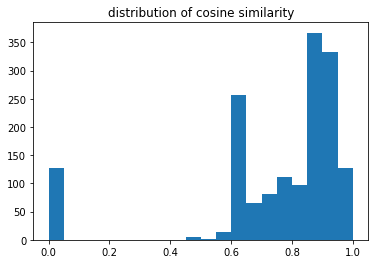

In [10]:
def q2_3():
    print("============")
    g = load_graph_weights()
    v_mat = cal_initial_feature(g)
    for k in range(2):
        v_mat = aggregrate(v_mat, g)
    v_9 = v_mat[9]

    cos_sim = [(i, cal_cos_sim(v_9, v)) for i, v in enumerate(v_mat)]
    cos_sim.sort(key=lambda y: y[1], reverse=True)
    cos_sims = [u[1] for u in cos_sim]
    plt.hist(cos_sims, bins=20)
    plt.title("distribution of cosine similarity")
    plt.show()

    node_1, sim_1 = find_node(0, 0.05, cos_sim)
    subg_1 = get_2_nd_subgraph(node_1, g)
    subg_1_h = snap.TIntStrH()
    subg_1_h[node_1] = "blue"
    subg_1 = snap.ConvertSubGraph(snap.PUNGraph, g, subg_1)
    snap.DrawGViz(subg_1, snap.gvlNeato, "subgraph_1.png", "subgraph 1 sim: {0}".format(round(sim_1,2)), True, subg_1_h)


    node_2 = 9#find_node(0.4, 0.45, cos_sim)
    subg_2 = get_2_nd_subgraph(node_2, g)
    subg_2_h = snap.TIntStrH()
    subg_2_h[node_2] = "blue"
    subg_2 = snap.ConvertSubGraph(snap.PUNGraph, g, subg_2)
    snap.DrawGViz(subg_2, snap.gvlNeato, "subgraph_center_9.png", "subgraph_center_9", True, subg_2_h)

    node_3, sim_3 = find_node(0.6, 0.65, cos_sim)
    subg_3 = get_2_nd_subgraph(node_3, g)
    subg_3_h = snap.TIntStrH()
    subg_3_h[node_3] = "blue"
    subg_3 = snap.ConvertSubGraph(snap.PUNGraph, g, subg_3)
    snap.DrawGViz(subg_3, snap.gvlNeato, "subgraph_3.png", "subgraph 3 sim: {0}".format(round(sim_3,2)), True, subg_3_h)

    node_4, sim_4 = find_node(0.9, 0.95, cos_sim)
    subg_4 = get_2_nd_subgraph(node_4, g)
    subg_4_h = snap.TIntStrH()
    subg_4_h[node_4] = "blue"
    subg_4 = snap.ConvertSubGraph(snap.PUNGraph, g, subg_4)
    snap.DrawGViz(subg_4, snap.gvlNeato, "subgraph_4.png", "subgraph 4 sim: {0}".format(round(sim_4,2)), True, subg_4_h)

    print("============")
q2_3()

From the picture we can observe 3 groups/roles.

Randomly select a point for each group and draw the subgraph of its 2nd neighbors as below: Note that Subgraph 1, Subgraph 3, Subgraph 4 are the three corresponding samples and the 2-nd figure is the 2-nd neighbor sampling for node 9. We can see that as closer to the neighbor distribution of node 9, the similarity score will be higher.